# GCNNによって隣接行列からノードの座標の予測する

## Colabで実行するときの設定

## 実験条件

- ネットワーク: GCNN
- 目的：隣接行列を生成した数字の予測
- edge weight: 使用
- epoch: 100
- 拡散時間t=20, ビーズの数nBeads=100
- 作った隣接行列：1~9の各クラスで100ずつ
- バッチサイズ：128

In [11]:
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from scipy.io import mmread
from sklearn.model_selection import train_test_split
import random
import networkx as nx
import math
import os
import os.path as osp
from natsort import natsorted

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.transforms import Compose
from torch_scatter import  scatter

# random seed
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
test_run = True
add_noise = True

if test_run:
    # プログラムが動くかどうかのテスト用の小さいデータ
    train_root = osp.join("small_data_coords","train")
    val_root = osp.join("small_data_coords","val")
    test_root = osp.join("small_data_coords","test")
    
    epoch_num = 3
    batch_size = 128
else:
    # 本番用データ   
    train_root = osp.join("data_coords","train")
    val_root = osp.join("data_coords","val")
    test_root = osp.join("data_coords","test")    
    
    epoch_num = 100
    batch_size = 128

## データの用意

### Dataset, DataLoaderの作成

In [37]:
class EdgeAttrInvert():
    r"""raise edge_attr to the power p"""
    def __init__(self,p=-1.0):
        self.p = p
        
    def __call__(self, data):
        data.edge_attr = data.edge_attr**self.p
        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
# TODO: ノイズを生成するクラスを作成しtransformに加える 


    
class MyOwnDataset(Dataset):
    
    processed_file_name = 'data_{}.pt'
    
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)

    @property
    def processed_file_names(self):
        num_graph = len(os.listdir(osp.join(self.raw_dir,"adj")))
        return [self.processed_file_name.format(i) for i in range(num_graph)]

    def process(self):
        adj_file_names = natsorted(os.listdir(osp.join(self.raw_dir,"adj")))
        coords_file_names = natsorted(os.listdir(osp.join(self.raw_dir,"coords")))
        
        for i, (adj_file_name,coords_file_name) in enumerate(zip(adj_file_names,coords_file_names)):
            adj_coo = mmread(osp.join(self.raw_dir, "adj", adj_file_name))
            coords_nda = mmread(osp.join(self.raw_dir, "coords", coords_file_name)).toarray()
            
            num_beads = adj_coo.shape[0]
            num_edges = adj_coo.nnz
            nnf = 1  ## nnf: num_node_features
            
            data = Data(
                x=torch.ones((num_beads, nnf)).float(),
                edge_index=torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long),
                edge_attr=torch.tensor(adj_coo.data.reshape(num_edges, -1)).float(),
                pos=torch.tensor(coords_nda).float()
            )
                        
            
            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            
            
            torch.save(data, osp.join(self.processed_dir, self.processed_file_name.format(i)))

        
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data

In [38]:
eai = EdgeAttrInvert(p=-1.0)
my_transform = transforms.Compose([eai])

train_set = MyOwnDataset(train_root,transform=my_transform)
val_set = MyOwnDataset(val_root,transform=my_transform)
test_set = MyOwnDataset(test_root,transform=my_transform)

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

Processing...
Done!
Processing...
Done!
Processing...
Done!


## モデルの定義

### ネットワークの定義

In [55]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: 入力グラフのチャネル数への依存をなくす
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.conv5 = GCNConv(64, 96)
        self.conv6 = GCNConv(96, 128)
        self.linear1 = torch.nn.Linear(128,64)
        #TODO: 分類数への依存をなくす
        self.linear2 = torch.nn.Linear(64,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #edge_weightとして用いるedge_attrのshapeが(n,1)だとうまくいかない．
        #edge_attr.shapeが(n,)だと動く．おそらくPyG側のバグ？
        edge_weight = torch.squeeze(data.edge_attr)
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv6(x, edge_index, edge_weight)
        x = F.relu(x)
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        """
        #x = scatter(x, data.batch, dim=0, reduce="max")
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

### 学習

In [56]:
nDim = train_set[0].pos.shape[1]  ## 各頂点の座標の次数

start = time.time()
# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print("device:", device)

train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(epoch_num):
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        prediction = model(batch)

        loss = criterion(prediction, batch.pos)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().item() * nDim
        if i % 10 == 9:
            progress_bar = '['+('='*((i+1)//10))+(' '*((train_size//100-(i+1))//10))+']'
            print('\repoch: {:d} loss: {:.3f}  {}'
                .format(
                    epoch + 1,
                    loss.cpu().item() * nDim,  # 表示するlossはノード間の距離の二条の平均
                    progress_bar),
                end="  ")

    print('\repoch: {:d} loss: {:.3f}'
        .format(epoch + 1, train_loss / math.ceil(train_size / batch_size)), end="  ")
    history["train_loss"].append(train_loss / math.ceil(train_size / batch_size))

    batch_num = 0
    loss = 0
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            data = data.to(device)
            prediction = model(data)
            loss += criterion(prediction, data.pos) * nDim
            batch_num += 1

    history["val_loss"].append(loss.cpu().item()/batch_num)
    endstr = ' '*max(1,(train_size//1000-39))+"\n"
    print(f'Val Loss: {loss.cpu().item()/batch_num:.3f}',end=endstr)


print('Finished Training')
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

device: cpu
epoch: 1 loss: 1.300  Val Loss: 1.177 
epoch: 2 loss: 1.294  Val Loss: 1.176 
epoch: 3 loss: 1.288  Val Loss: 1.175 
Finished Training
elapsed time: 0:00:00


## 可視化

#### 座標予測用の可視化

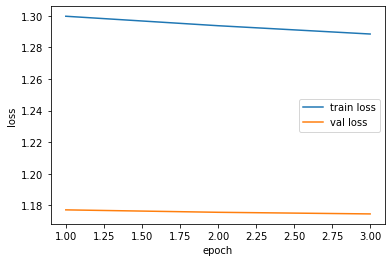

In [57]:
# 損失
plt.xlabel("epoch")
plt.ylabel("loss")

x = np.arange(epoch_num) + 1
plt.plot(x, history["train_loss"], label="train loss")
plt.plot(x, history["val_loss"], label="val loss")
plt.legend()
plt.show()

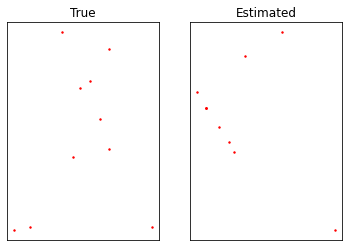

In [72]:
t_index = 0
nBeads = train_set[0].num_nodes

node_list = list(range(nBeads))

test_data = test_set[t_index].to(device)

# テストデータのノードの座標を予想
with torch.no_grad():
    model.eval()
    estimated_coords = model(test_data)
    
# 描画のためのグラフを作成
test_edge_indices = torch.t(test_data.edge_index).to('cpu').detach().numpy()
true_coords = test_data.pos.to('cpu').detach().numpy().copy()

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(test_edge_indices)

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("True")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Estimated")

true_pos = dict(zip(node_list, true_coords))
#nx.draw_networkx(G, pos=true_pos, with_labels=False, ax=ax1,
#                 node_color="red", node_size=2)
nx.draw_networkx_nodes(G, pos=true_pos, ax=ax1, node_color="red", node_size=2)

estimated_pos = dict(zip(node_list, estimated_coords.cpu().detach().numpy()))
#nx.draw_networkx(G, pos=estimated_pos, with_labels=False, ax=ax2,
#                 node_color="red", node_size=2)
nx.draw_networkx_nodes(G, pos=estimated_pos, ax=ax2, node_color="red", node_size=2)

plt.show()

## 実験条件

In [73]:
nSmaples = len(train_set)
t = 20

print("=====Simulation conditions=====")
print("目的：隣接町列を生成した数字の予測")
print("ネットワーク：GCNN")
print("Test run: {}".format(test_run))
print("Number of beads: {}".format(nBeads))
print("Number of samples for training: {}".format(nSmaples))
print("Add noise: {}".format(add_noise))
print("Number of epochs: {}".format(epoch_num))
print("Batch size: {}".format(batch_size))
print("Diffusion time: {}".format(t))

print("=====Results=====")
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

=====Simulation conditions=====
目的：隣接町列を生成した数字の予測
ネットワーク：GCNN
Test run: True
Number of beads: 10
Number of samples for training: 72
Add noise: True
Number of epochs: 3
Batch size: 128
Diffusion time: 20
=====Results=====
elapsed time: 0:00:00
